# **Project 2**

## Data Preparation

In [1]:
## Import tensorflow and all other relvant libraries
from numpy.random import seed
seed(2)
import tensorflow as tf
tf.random.set_seed(4)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing import image
import os

In [2]:
os.getcwd()

'/workspace'

In [3]:
with zipfile.ZipFile('/workspace/archive.zip') as zip_ref:
    zip_ref.extractall()

In [4]:
## Import pretrained convnet and model callback modules

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception

In [5]:
## Create training, testing, and prediction datasets

trainDIR = '/workspace/seg_train/seg_train/'
testDIR = '/workspace/seg_test/seg_test/'
predDIR = '/workspace/seg_pred/seg_pred'

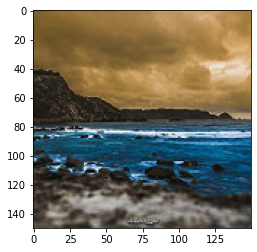

In [6]:
## Show random image from prediction data

r_img = image.load_img(predDIR+r'/'+"10127.jpg")
r_img_tensor = image.img_to_array(r_img)
r_img_tensor = np.expand_dims(r_img_tensor,axis=0)
r_img_tensor/=255.
plt.imshow(r_img_tensor[0])
plt.show()

In [7]:
## Create function to pull labels and images from traning and testing data, where each image is converted
## to a 150 x 150 x 3 array

def get_images(directory):
    Images=[]
    Labels=[]
    
    for labels in os.listdir(directory):
        if labels == 'glacier':
            label = 0
        elif labels == 'sea':
            label = 1
        elif labels == 'buildings':
            label = 2
        elif labels == 'forest':
            label = 3
        elif labels == 'mountain':
            label = 4
        elif labels == 'street':
            label = 5
        
        for file in os.listdir(directory+labels):
            im =  image.load_img(directory+labels+r'/'+file, target_size=(150,150))
            img = image.img_to_array(im)
            Images.append(img)
            Labels.append(label)
    
    Images, Labels = sklearn.utils.shuffle(Images, Labels, random_state=14)
    return Images, Labels

In [8]:
Images, Labels = get_images(trainDIR)
Images = np.array(Images)
Labels = np.array(Labels)

In [9]:
Images.shape

(14034, 150, 150, 3)

In [10]:
Labels.shape

(14034,)

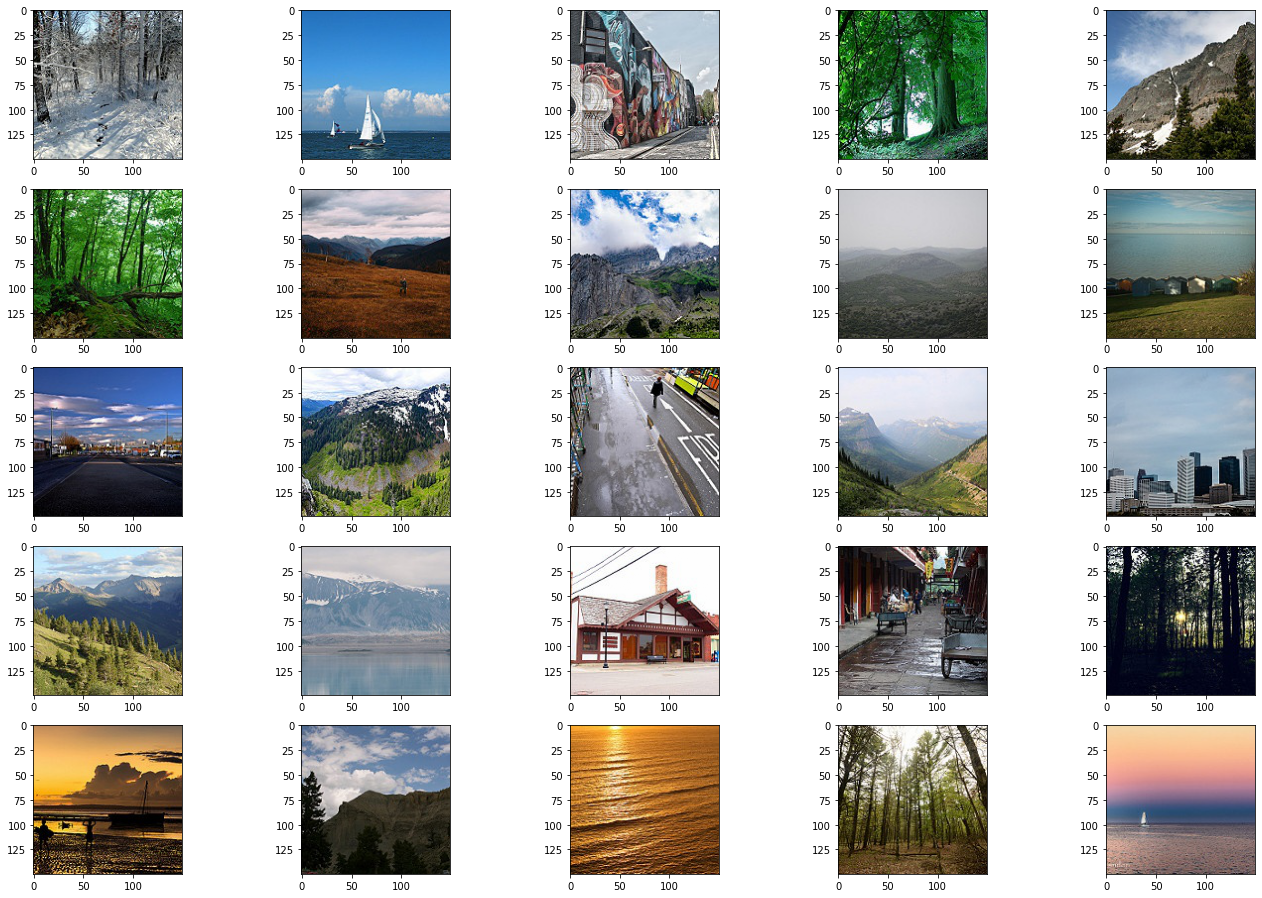

In [11]:
## Create 5x5 grid of randomly sampled images from training data

f, ax = plt.subplots(5,5)
f.subplots_adjust(0,0,3,3)

for i in range(0,5):
    for j in range(0,5):
        rand = np.random.randint(0,len(Images))
        img = Images[rand]
        img = np.expand_dims(img, axis=0)
        img/=255.
        ax[i,j].imshow(img[0])

## Model 1

In [12]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6,'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               87616500  
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

In [13]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
callbacks_list1 = [ReduceLROnPlateau(monitor='val_accuracy',
                                factor=0.1,
                                patience=3),
                  EarlyStopping(monitor='val_accuracy',
                               patience=5)
                 ]

In [15]:
fitted = model.fit(Images, Labels,
         epochs=20,
         validation_split=0.25,
         callbacks=callbacks_list1)

Epoch 1/20
329/329 [==============================] - 5s 15ms/step - loss: 1.0289 - accuracy: 0.6665 - val_loss: 0.9137 - val_accuracy: 0.6902
Epoch 2/20
329/329 [==============================] - 5s 15ms/step - loss: 0.3820 - accuracy: 0.8714 - val_loss: 1.8211 - val_accuracy: 0.5366
Epoch 3/20
329/329 [==============================] - 5s 15ms/step - loss: 0.1998 - accuracy: 0.9374 - val_loss: 0.8053 - val_accuracy: 0.7475
Epoch 4/20
329/329 [==============================] - 5s 15ms/step - loss: 0.1182 - accuracy: 0.9659 - val_loss: 1.0188 - val_accuracy: 0.7424
Epoch 5/20
329/329 [==============================] - 5s 15ms/step - loss: 0.0787 - accuracy: 0.9788 - val_loss: 1.2478 - val_accuracy: 0.6991
Epoch 6/20
329/329 [==============================] - 5s 15ms/step - loss: 0.0808 - accuracy: 0.9762 - val_loss: 1.1776 - val_accuracy: 0.7184
Epoch 7/20
329/329 [==============================] - 5s 14ms/step - loss: 0.0380 - accuracy: 0.9909 - val_loss: 0.8203 - val_accuracy: 0.7737

In [16]:
model.save_weights('first_model.h5')

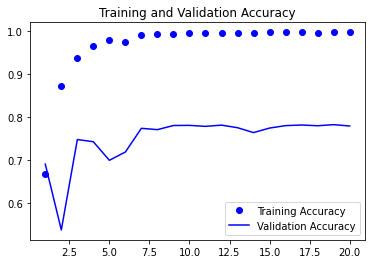

In [17]:
acc = fitted.history['accuracy']
val_acc  = fitted.history['val_accuracy']
loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

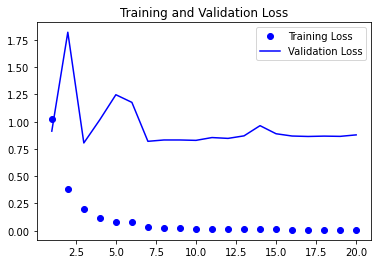

In [18]:
plt.clf()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model 2

In [19]:
model2 = Sequential()
model2.add(Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model2.add(MaxPooling2D((2,2)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(1000,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(500,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(6, activation='softmax'))

In [20]:
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
history = model2.fit(Images, Labels, 
                    epochs=20,
                    validation_split=0.25,
                    callbacks=callbacks_list1)

Epoch 1/20
329/329 [==============================] - 6s 18ms/step - loss: 0.9026 - accuracy: 0.6771 - val_loss: 1.1790 - val_accuracy: 0.6247
Epoch 2/20
329/329 [==============================] - 5s 16ms/step - loss: 0.5748 - accuracy: 0.7906 - val_loss: 1.2723 - val_accuracy: 0.6404
Epoch 3/20
329/329 [==============================] - 5s 16ms/step - loss: 0.4063 - accuracy: 0.8532 - val_loss: 0.7425 - val_accuracy: 0.7472
Epoch 4/20
329/329 [==============================] - 5s 16ms/step - loss: 0.2618 - accuracy: 0.9092 - val_loss: 0.9558 - val_accuracy: 0.7199
Epoch 5/20
329/329 [==============================] - 5s 16ms/step - loss: 0.1630 - accuracy: 0.9443 - val_loss: 1.3231 - val_accuracy: 0.6478
Epoch 6/20
329/329 [==============================] - 5s 16ms/step - loss: 0.1264 - accuracy: 0.9566 - val_loss: 1.2696 - val_accuracy: 0.7019
Epoch 7/20
329/329 [==============================] - 5s 16ms/step - loss: 0.0510 - accuracy: 0.9832 - val_loss: 0.6488 - val_accuracy: 0.8239

In [22]:
model2.save_weights('second_model.h5')

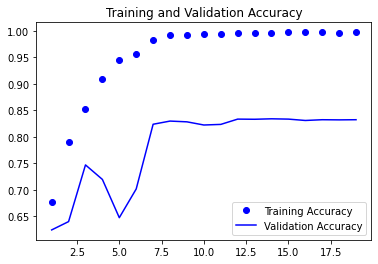

In [23]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

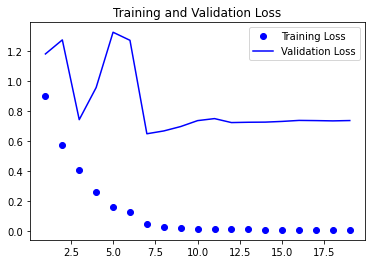

In [24]:
plt.clf()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model 3: Pretrained Convolutional Neural Network (Xception)

In [25]:
conv_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(150,150,3))

In [26]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [27]:
conv_base.trainable=True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block14_speconv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [28]:
model3 = tf.keras.models.Sequential()

model3.add(conv_base)
model3.add(Flatten())
model3.add(Dense(256,activation='relu'))
model3.add(Dense(6,activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])

In [29]:
history = model3.fit(Images, Labels,
          epochs=30,
          validation_split=0.25)

Epoch 1/30
329/329 [==============================] - 11s 33ms/step - loss: 3.8428 - accuracy: 0.5132 - val_loss: 2.2881 - val_accuracy: 0.5916
Epoch 2/30
329/329 [==============================] - 10s 29ms/step - loss: 1.7506 - accuracy: 0.6402 - val_loss: 1.9245 - val_accuracy: 0.6184
Epoch 3/30
329/329 [==============================] - 10s 29ms/step - loss: 1.2869 - accuracy: 0.6938 - val_loss: 1.7106 - val_accuracy: 0.6395
Epoch 4/30
329/329 [==============================] - 10s 29ms/step - loss: 0.9854 - accuracy: 0.7403 - val_loss: 1.5749 - val_accuracy: 0.6597
Epoch 5/30
329/329 [==============================] - 10s 29ms/step - loss: 0.7871 - accuracy: 0.7795 - val_loss: 1.4998 - val_accuracy: 0.6728
Epoch 6/30
329/329 [==============================] - 10s 29ms/step - loss: 0.6342 - accuracy: 0.8172 - val_loss: 1.5276 - val_accuracy: 0.6834
Epoch 7/30
329/329 [==============================] - 10s 29ms/step - loss: 0.5055 - accuracy: 0.8426 - val_loss: 1.5698 - val_accuracy:

In [30]:
model3.save_weights("model3.h5")

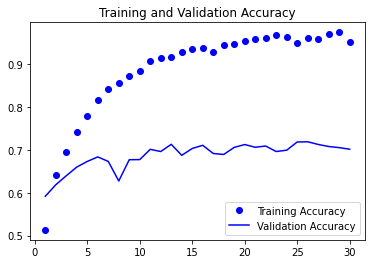

In [31]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

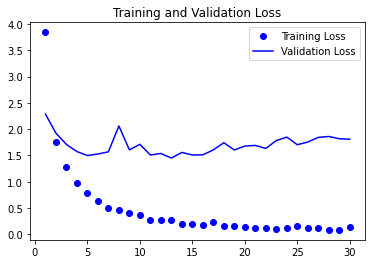

In [32]:
plt.clf()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model 4: ImageDataGenerator-based Model

In [33]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  horizontal_flip=True,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  validation_split=0.25)

train_generator = train_datagen.flow_from_directory(trainDIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(testDIR,
                                                 batch_size=32,
                                                 target_size=(150,150),
                                                 class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [34]:
model4 = Sequential()
model4.add(Conv2D(200, (3,3), activation='relu', input_shape=(150,150,3)))
model4.add(MaxPooling2D(5,5))
model4.add(Conv2D(150, (3,3), activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Flatten())
model4.add(Dense(256,activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(6,activation='softmax'))

In [35]:
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
callbacks_list2 = [ReduceLROnPlateau(monitor='accuracy',
                                factor=0.1,
                                patience=3),
                  EarlyStopping(monitor='accuracy',
                               patience=5)
                 ]

In [37]:
history = model4.fit(train_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              callbacks=callbacks_list2,
                              validation_steps=100)

Epoch 1/15
100/100 [==============================] - 12s 119ms/step - loss: 1.5478 - accuracy: 0.3453
Epoch 2/15
100/100 [==============================] - 12s 117ms/step - loss: 1.2484 - accuracy: 0.5038
Epoch 3/15
100/100 [==============================] - 12s 116ms/step - loss: 1.1754 - accuracy: 0.5359
Epoch 4/15
100/100 [==============================] - 12s 116ms/step - loss: 1.1444 - accuracy: 0.5441
Epoch 5/15
100/100 [==============================] - 12s 120ms/step - loss: 1.1086 - accuracy: 0.5612
Epoch 6/15
100/100 [==============================] - 12s 119ms/step - loss: 1.0571 - accuracy: 0.5825
Epoch 7/15
100/100 [==============================] - 12s 115ms/step - loss: 1.0184 - accuracy: 0.6100
Epoch 8/15
100/100 [==============================] - 12s 119ms/step - loss: 1.0184 - accuracy: 0.6056
Epoch 9/15
100/100 [==============================] - 12s 117ms/step - loss: 0.9253 - accuracy: 0.6510
Epoch 10/15
100/100 [==============================] - 12s 115ms/step - l

In [38]:
model4.save_weights("model4.h5")

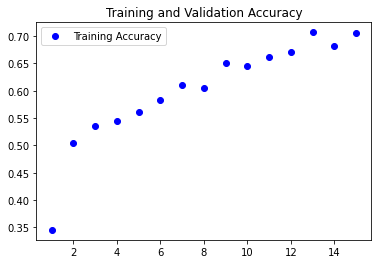

In [39]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

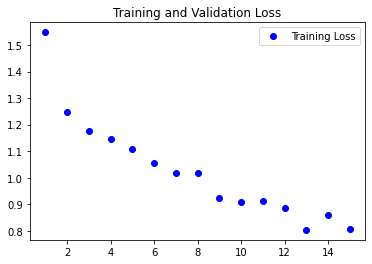

In [40]:
plt.clf()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Test Data Accuracy and Loss

In [41]:
test, test_labels = get_images(testDIR)

test = np.array(test)
test_labels = np.array(test_labels)

loss, acc = model.evaluate(test,test_labels)

94/94 [==============================] - 1s 6ms/step - loss: 0.9408 - accuracy: 0.7643


In [42]:
loss, acc = model2.evaluate(test,test_labels)

94/94 [==============================] - 1s 7ms/step - loss: 0.7097 - accuracy: 0.8347


In [43]:
loss, acc = model3.evaluate(test,test_labels)

94/94 [==============================] - 2s 23ms/step - loss: 1.9337 - accuracy: 0.6817


In [44]:
loss, acc = model4.evaluate(test_generator,steps=50)

50/50 [==============================] - 2s 36ms/step - loss: 0.6444 - accuracy: 0.7731


## Visualizations of Activations and Filters/Kernels

In [45]:
layer_outputs = [layer.output for layer in model2.layers[:8]]
activation_model = tf.keras.models.Model(inputs=model2.input, outputs=layer_outputs)
activations = activation_model.predict(r_img_tensor)

first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 64)

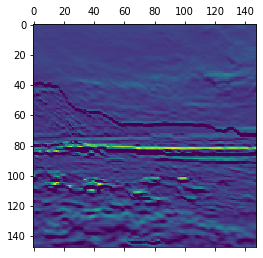

In [46]:
plt.matshow(first_layer_activation[0,:,:,2])
plt.show()

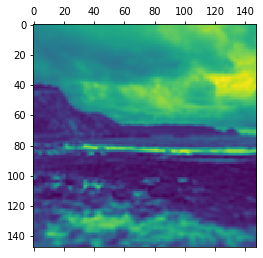

In [66]:
plt.matshow(first_layer_activation[0,:,:,60])
plt.show()

In [48]:
layer_name = 'block3_sepconv1_act'

In [49]:
model5 = conv_base
layer = model5.get_layer(layer_name)
feature_extractor = tf.keras.Model(inputs=model5.inputs, outputs=layer.output)

In [50]:
def compute_loss(input_img, filter_index):
    activation = feature_extractor(input_img)
    filter_activation = activation[:,2:-2, 2:-2,filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, lr):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss= compute_loss(img, filter_index)
        grads=tape.gradient(loss,img)
        grads = tf.math.l2_normalize(grads)
        img+=lr*grads
        return loss, img

def initialize_image():
    img = tf.random.uniform((1,img_width, img_height, 3))
    return (img - 0.5)*0.25

def visualize_filter(filter_index):
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img,filter_index, learning_rate)
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    img-=img.mean()
    img /= img.std() + 1e-5
    img*=0.15
    
    img = img[25:-25, 25:-25,:]
    
    img += 0.5
    img = np.clip(img, 0, 1)
    
    img*=255
    img=np.clip(img,0,255).astype('uint8')
    return img

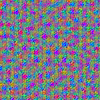

In [51]:
from IPython.display import Image, display

img_width = 150
img_height = 150

loss, img = visualize_filter(0)
image.save_img("0.png", img)
display(Image("0.png"))

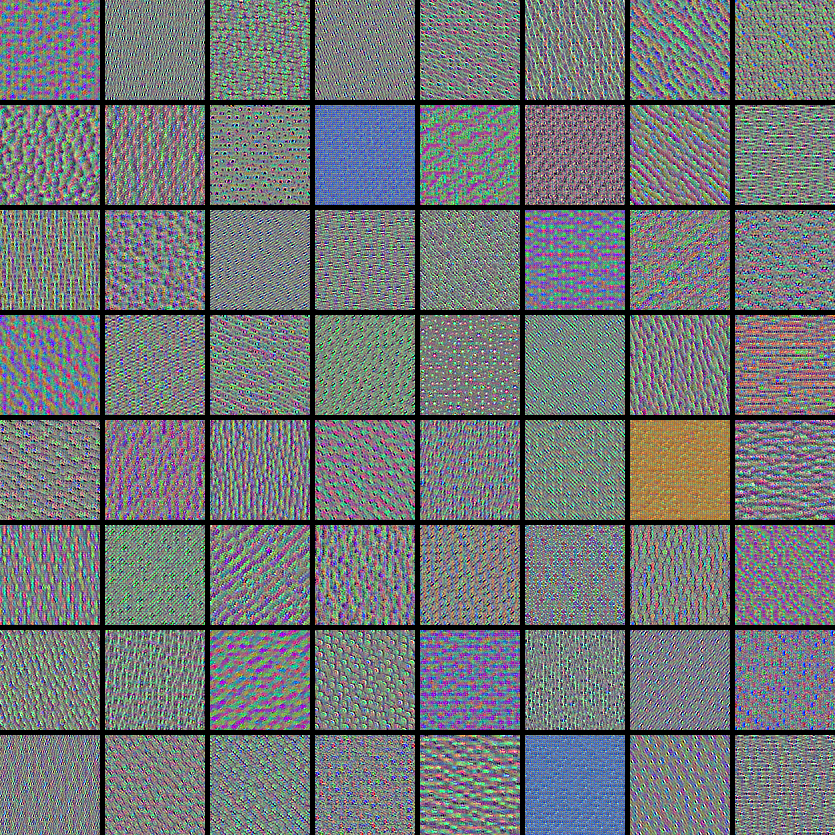

In [52]:
all_imgs=[]

for filter_index in range(64):
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)
    
    
margin=5
n=8
cropped_width = img_width - 25 *2
cropped_height = img_height - 25*2
width= n * cropped_width + (n-1)*margin
height = n*cropped_height + (n-1)*margin
stitched_filters = np.zeros((width, height, 3))


for i in range(n):
    for j in range(n):
        img=all_imgs[i*n+j]
        stitched_filters[(cropped_width+margin)*i : (cropped_width + margin) * i + cropped_width,
                        (cropped_height + margin)*j : (cropped_height + margin) * j + cropped_height, :, ] = img
        image.save_img('stitched_filters.png', stitched_filters)

display(Image("stitched_filters.png"))
        

In [53]:
test.shape

(3000, 150, 150, 3)

In [54]:
test_labels.shape

(3000,)

## Classification Metrics

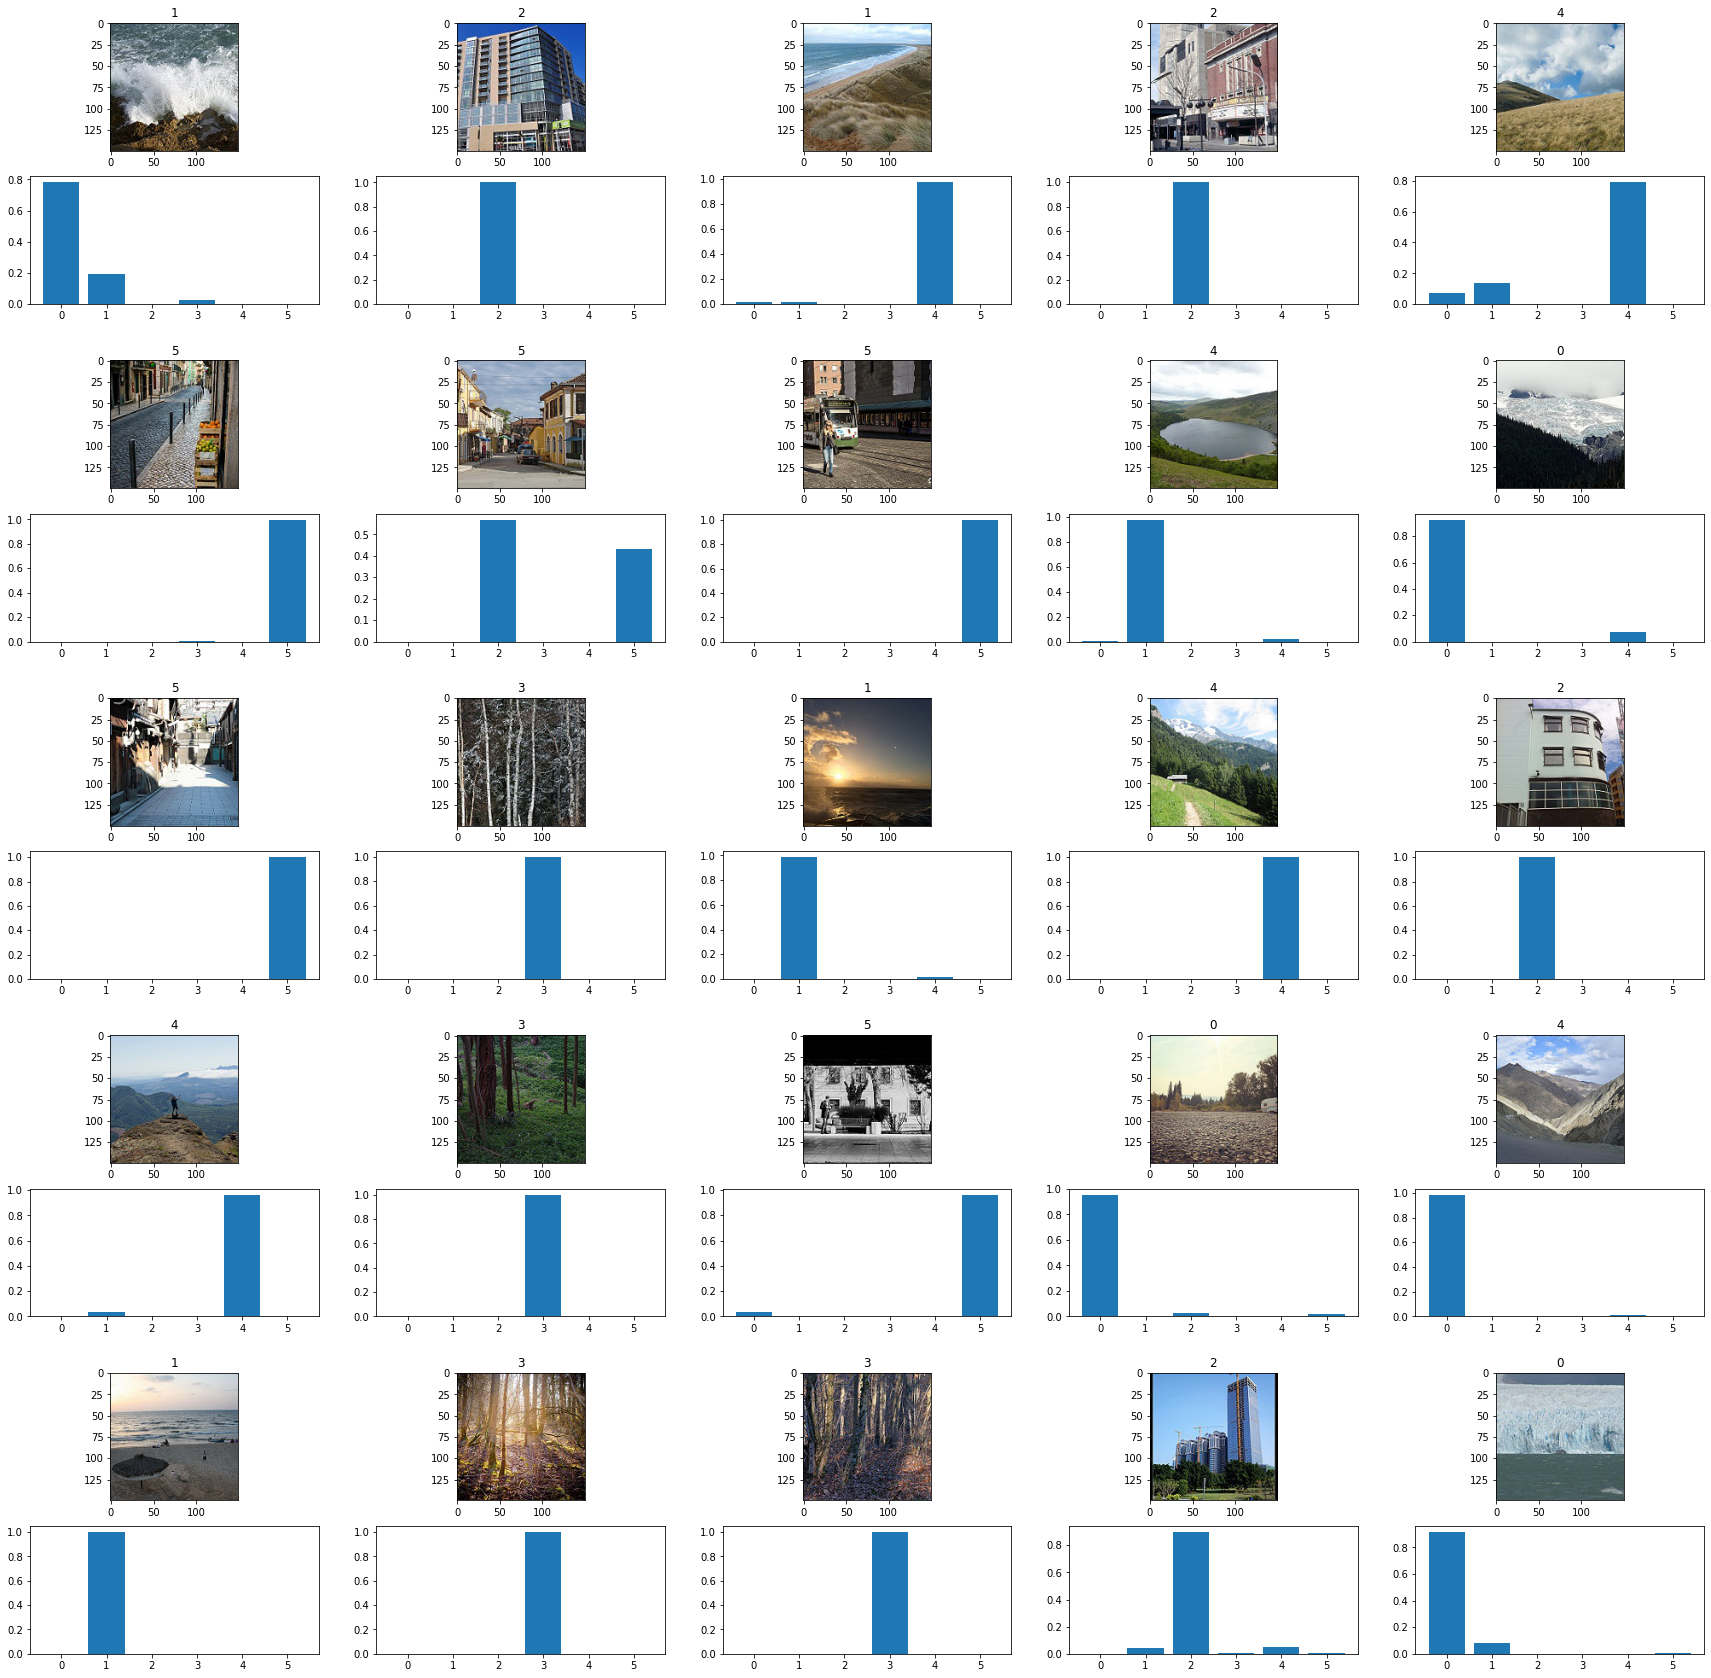

In [55]:
import matplotlib
fig = plt.figure(figsize=(30,30))
outer = matplotlib.gridspec.GridSpec(5,5)

for i in range(25):
    inner = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=outer[i])
    rand = np.random.randint(0,len(test))
    pred_img = np.array([test[rand]])
    actual_class = test_labels[rand]
    pred_prob = model2.predict(pred_img).reshape(6)
    
    for j in range(2):
        ax = plt.Subplot(fig,inner[j])
        if(j%2) == 0:
            pred_img/=255.
            ax.imshow(pred_img[0])
            ax.set_title(actual_class)
        else:
            ax.bar([0,1,2,3,4,5], pred_prob)
        fig.add_subplot(ax)

In [56]:
label_names = np.unique(Labels)
len(label_names)

6

In [57]:
num_labels = len(label_names)

In [58]:
predictions = model2.predict(test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


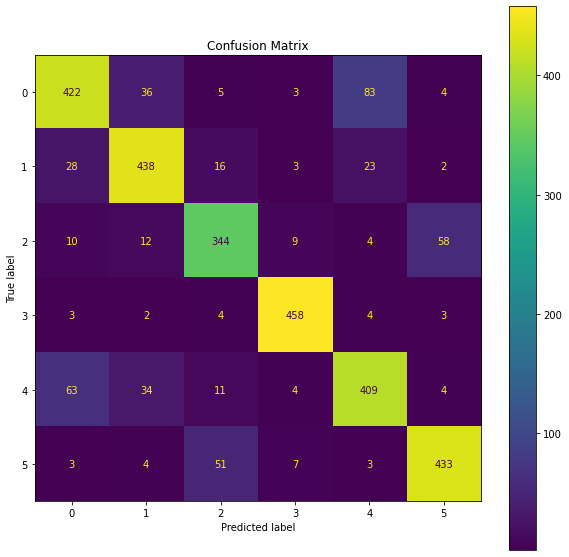

In [59]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, np.argmax(predictions,axis=1), labels=label_names)

disp = ConfusionMatrixDisplay(cm, label_names)

disp = disp.plot()
plt.title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [60]:
y_test = tf.keras.utils.to_categorical(test_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


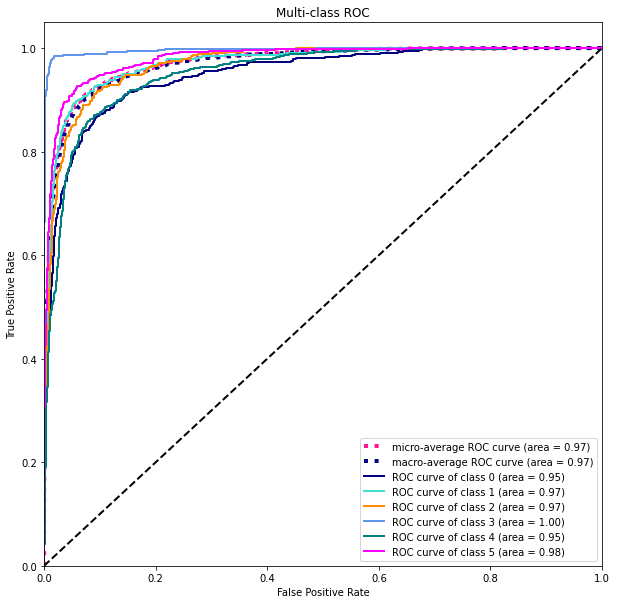

In [61]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal','magenta']
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test, predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.90


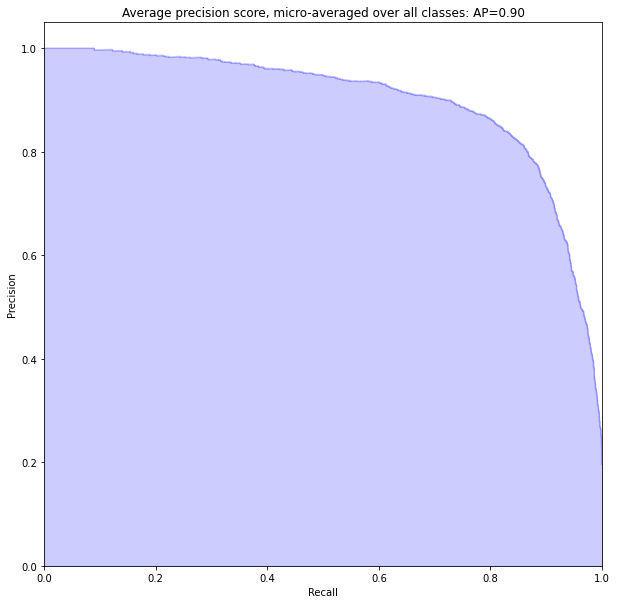

In [63]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
fig = plt.gcf()
fig.set_size_inches(10,10)

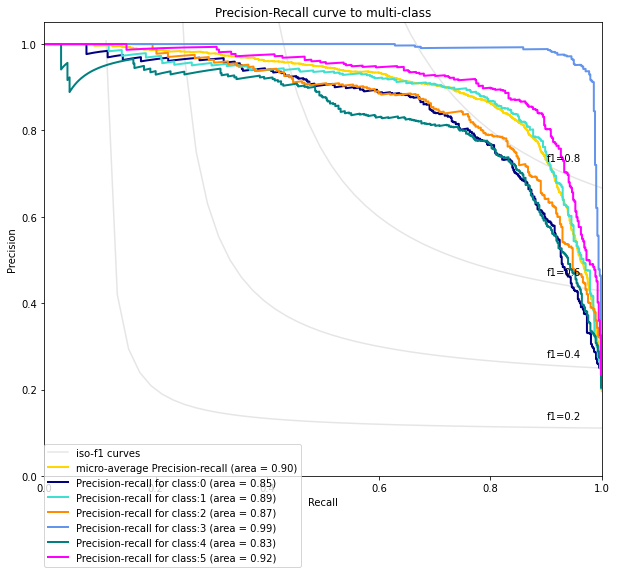

In [64]:
from itertools import cycle
# setup plot details
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal','magenta']

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.show()

In [65]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovo = roc_auc_score(y_test, predictions, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, predictions, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, predictions, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, predictions, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.969782 (macro),
0.969052 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.969782 (macro),
0.969052 (weighted by prevalence)
